# Supervised Machine Learning - Classification

#### Imports

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

## Level 1

### Exercise 1

#### Create 3 different models of classification for prediction of ArrDelay

Prediction model for one airline and one destination, target arrival delay.
- Destination to Las Vegas - code LAS
- Most frequent airline Southwest Airlines - code WN
- Considering if the flight arrived late or not ArrDelay > 0

In [7]:
df = pd.read_csv("DelayedFlights.csv")
df.head(3)

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,...,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,...,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628.0,620,804.0,750,WN,...,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN


In [16]:
df.columns

Index(['Unnamed: 0', 'Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime',
       'CRSDepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum',
       'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

In [17]:
#retrieve the data
a = df.loc[df['Dest'] == 'LAS']
b = a.loc[df['UniqueCarrier'] == 'WN']
df_flights = b[['Month', 'DayofMonth', 'DayOfWeek',
                'CRSArrTime','CRSElapsedTime','ArrDelay',
                'DepDelay','TaxiIn', 'TaxiOut','Cancelled']]
df_flights.head(3)

,Month,DayofMonth,DayOfWeek,CRSArrTime,CRSElapsedTime,ArrDelay,DepDelay,TaxiIn,TaxiOut,Cancelled
5,1,3,4,1940,250.0,57.0,67.0,3.0,7.0,0
243,1,3,4,1530,65.0,24.0,36.0,4.0,8.0,0
244,1,3,4,1240,65.0,33.0,30.0,3.0,18.0,0


In [18]:
#deleting rows with cancelled flights
df_flights = df_flights.loc[df_flights['Cancelled'] == 0]
df_flights.drop('Cancelled',axis=1, inplace=True)
df_flights.head(3)

,Month,DayofMonth,DayOfWeek,CRSArrTime,CRSElapsedTime,ArrDelay,DepDelay,TaxiIn,TaxiOut
5,1,3,4,1940,250.0,57.0,67.0,3.0,7.0
243,1,3,4,1530,65.0,24.0,36.0,4.0,8.0
244,1,3,4,1240,65.0,33.0,30.0,3.0,18.0


In [19]:
#arrdelay > 0 or not? 1-yes, 0-not
df_flights['Label'] = np.where(df_flights['ArrDelay'] > 0, 1, 0)
df_flights.reset_index(inplace=True,drop=True)
df_flights.head(3)

,Month,DayofMonth,DayOfWeek,CRSArrTime,CRSElapsedTime,ArrDelay,DepDelay,TaxiIn,TaxiOut,Label
0,1,3,4,1940,250.0,57.0,67.0,3.0,7.0,1
1,1,3,4,1530,65.0,24.0,36.0,4.0,8.0,1
2,1,3,4,1240,65.0,33.0,30.0,3.0,18.0,1


In [20]:
df_flights.shape

(25226, 10)

In [21]:
#Do I have complete values dataset? How many NaN values I have?
df_flights.isnull().sum()

Month               0
DayofMonth          0
DayOfWeek           0
CRSArrTime          0
CRSElapsedTime      0
ArrDelay          138
DepDelay            0
TaxiIn            135
TaxiOut             0
Label               0
dtype: int64

In [22]:
#arithmetic mean for missing values
df_flights['ArrDelay']=df_flights['ArrDelay'].fillna(df_flights['ArrDelay'].mean())
df_flights['TaxiIn']=df_flights['TaxiIn'].fillna(df_flights['TaxiIn'].mean())

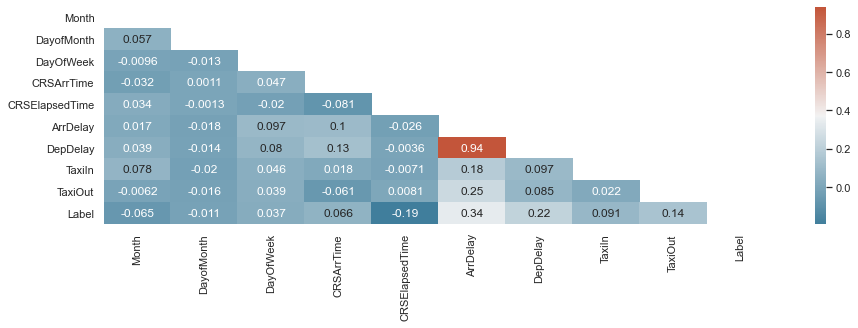

In [23]:
#Correlation matrix - ajusting input values acording this map -  better not to get high correlations
fig,ax = plt.subplots(figsize=(15,4))
corr = df_flights.corr()
sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)

matrix = np.triu(corr)
sns.heatmap(corr, annot=True, mask=matrix, cmap=cmap)
plt.show()

#### Train and test samples

I will work with stratified random sample to have all values proportionaly included (ArrDelay=0, ArrDelay=1).

In [24]:
#stratified random sample - take 50 flights with delay and 50 with no delay
group1 = df_flights[df_flights['Label'] == 0]
group2 = df_flights[df_flights['Label'] == 1]
flights_df1 = group1.sample(n = 100)
flights_df2 = group2.sample(n = 100)
df_flights_sample = flights_df1.append((flights_df2),ignore_index = True)
df_flights_sample.head(3)

,Month,DayofMonth,DayOfWeek,CRSArrTime,CRSElapsedTime,ArrDelay,DepDelay,TaxiIn,TaxiOut,Label
0,12,26,5,1715,70.0,-1.0,7.0,13.0,9.0,0
1,11,29,6,935,335.0,-10.0,8.0,3.0,14.0,0
2,9,29,1,1700,130.0,-1.0,6.0,8.0,8.0,0


In [25]:
X = df_flights_sample.drop('Label',axis=1)
y = df_flights_sample['Label']
#Train 70%, test 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [26]:
print(X_train.shape,y_train.shape, X_test.shape, y_test.shape)

(140, 9) (140,) (60, 9) (60,)


In [27]:
#scaling the values
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### Decision tree classifier

In [28]:
model1 = DecisionTreeClassifier(criterion='gini', splitter='random')
model1 = model1.fit(X_train,y_train)
y_pred1 = model1.predict(X_test)

#### K-Nearest Neighbors classifier

In [29]:
model2 = KNeighborsClassifier()
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)

#### Support vector machine classifier

In [30]:
model3 = svm.SVC()
model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)

#### Logistic classifier

In [31]:
model4 = LogisticRegression()
model4.fit(X_train,y_train)
y_pred4 = model4.predict(X_test)

#### XGBoost classifier

In [33]:
model5 = xgb.XGBClassifier(objective='reg:logistic')
model5.fit(X_train,y_train)
predictions = model5.predict(X_test)
y_pred5 = [round(value) for value in predictions]

### Exercise 2

##### Compare these models with accuracy, confusion matrix and other advanced metrics

#### Accuracy

In [34]:
print('Accuracy decision tree model:',round(metrics.accuracy_score(y_test, y_pred1),2)*100,'%')
print('Accuracy KNN model:',round(metrics.accuracy_score(y_test, y_pred2),2)*100,'%')
print('Accuracy SVM model:',round(metrics.accuracy_score(y_test, y_pred3),2)*100,'%')
print('Accuracy Logistic model:',round(metrics.accuracy_score(y_test, y_pred4),2)*100,'%')
print('Accuracy XGBoost model:',round(metrics.accuracy_score(y_test, y_pred5),2)*100,'%')

Accuracy decision tree model: 90.0 %
Accuracy KNN model: 68.0 %
Accuracy SVM model: 77.0 %
Accuracy Logistic model: 82.0 %
Accuracy XGBoost model: 93.0 %


The XGBoost model and Decision Tree model have the best results in accuracy. Nevertheless this metrics doesn't distinguish in detail the errors (false positive and false negative). That's why we use other metrics like Sensitivity, Specificity, Precision and F1 score.

#### Confusion matrix

In [35]:
m1 = metrics.confusion_matrix(y_test, y_pred1)
m2 = metrics.confusion_matrix(y_test, y_pred2)
m3 = metrics.confusion_matrix(y_test, y_pred3)
m4 = metrics.confusion_matrix(y_test, y_pred4)
m5 = metrics.confusion_matrix(y_test, y_pred5)

print('Matrix decision tree model:',m1)
print('Matrix KNN model:',m2)
print('Matrix SVM model:',m3)
print('Matrix model:',m4)
print('Matrix XGBoost model:',m5)

Matrix decision tree model: [[28  3]
 [ 3 26]]
Matrix KNN model: [[22  9]
 [10 19]]
Matrix SVM model: [[26  5]
 [ 9 20]]
Matrix model: [[27  4]
 [ 7 22]]
Matrix XGBoost model: [[28  3]
 [ 1 28]]


The matrix means: [[true positive,false negative] [false positive,true negative]]

In [36]:
#sensitivity TP / (TP + FN)
s1 = m1[1,1] / (m1[1,1] + m1[1,0])
s2 = m2[1,1] / (m2[1,1] + m2[1,0])
s3 = m3[1,1] / (m3[1,1] + m3[1,0])
s4 = m4[1,1] / (m4[1,1] + m4[1,0])
s5 = m5[1,1] / (m5[1,1] + m5[1,0])

print('Sensitivity decision tree model:',s1)
print('Sensitivity KNN model:',s2)
print('Sensitivity SVM model:',s3)
print('Sensitivity Logistic model:',s4)
print('Sensitivity XGBoost model:',s5)

Sensitivity decision tree model: 0.896551724137931
Sensitivity KNN model: 0.6551724137931034
Sensitivity SVM model: 0.6896551724137931
Sensitivity Logistic model: 0.7586206896551724
Sensitivity XGBoost model: 0.9655172413793104


The Decision tree model and XGBoost model has the best results in test of sensitivity. Normally we would prefer a model with a maximum sensitivity, as it minimizes the occurrences of a type II error.

In [37]:
f1 = f1_score(y_test, y_pred1)
f2 = f1_score(y_test, y_pred2)
f3 = f1_score(y_test, y_pred3)
f4 = f1_score(y_test, y_pred4)
f5 = f1_score(y_test, y_pred5)

print('F1 score decision tree model:',f1)
print('F1 score KNN model:',f2)
print('F1 score SVM model:',f3)
print('F1 score Logistic model:',f4)
print('F1 score XGBoost model:',f5)

F1 score decision tree model: 0.896551724137931
F1 score KNN model: 0.6666666666666666
F1 score SVM model: 0.7407407407407408
F1 score Logistic model: 0.8
F1 score XGBoost model: 0.9333333333333333


F1 score summarizes both precision and recall.

#### ROC curve

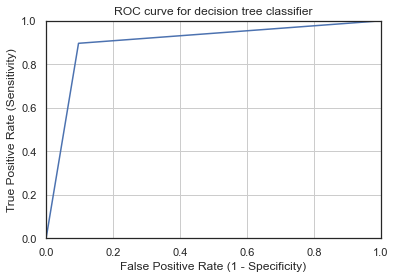

In [38]:
#ROC - summarizes the performance of the decision tree model at different threshold values
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, y_pred1)

plt.plot(fpr1, tpr1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for decision tree classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [41]:
def evaluate_threshold(threshold1):
    print('Sensitivity:', tpr1[thresholds1 > threshold1][-1])
    print('Specificity:', 1 - fpr1[thresholds1 > threshold1][-1])
evaluate_threshold(0.5)

Sensitivity: 0.896551724137931
Specificity: 0.9032258064516129


In [42]:
#AUC - area under the curve - the best is AUC=1
print('AUC of decision tree model:',round(metrics.roc_auc_score(y_test, y_pred1),2)*100,'%')

AUC of decision tree model: 90.0 %


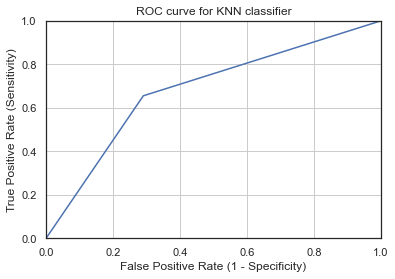

In [43]:
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test, y_pred2)

plt.plot(fpr2, tpr2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for KNN classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [44]:
def evaluate_threshold(threshold2):
    print('Sensitivity:', tpr2[thresholds2 > threshold2][-1])
    print('Specificity:', 1 - fpr2[thresholds2 > threshold2][-1])
evaluate_threshold(0.5)

Sensitivity: 0.6551724137931034
Specificity: 0.7096774193548387


In [46]:
#AUC - area under the curve
print('AUC of KNN model:',round(metrics.roc_auc_score(y_test, y_pred2),2)*100,'%')

AUC of KNN model: 68.0 %


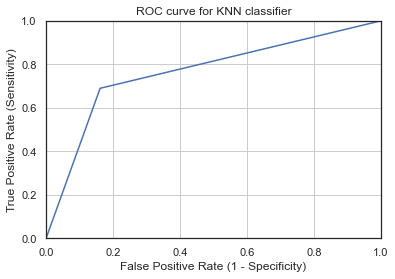

In [47]:
fpr3, tpr3, thresholds3 = metrics.roc_curve(y_test, y_pred3)

plt.plot(fpr3, tpr3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for KNN classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [110]:
def evaluate_threshold(threshold3):
    print('Sensitivity:', tpr3[thresholds3 > threshold3][-1])
    print('Specificity:', 1 - fpr3[thresholds3 > threshold3][-1])
evaluate_threshold(0.5)

Sensitivity: 0.7931034482758621
Specificity: 0.7419354838709677


In [48]:
#AUC - area under the curve
print('AUC of SVM model:',round(metrics.roc_auc_score(y_test, y_pred3),2)*100,'%')

AUC of SVM model: 76.0 %


### Exercise 3

##### Train models with different parameters

#### Decision tree classifier

In [49]:
model6 = DecisionTreeClassifier(criterion='entropy', splitter='best')
model6 = model6.fit(X_train,y_train)
y_pred6 = model6.predict(X_test)

#### K-Nearest Neighbors classifier

In [56]:
model7 = KNeighborsClassifier(n_neighbors=1, weights='distance',leaf_size=50)
model7.fit(X_train, y_train)
y_pred7 = model7.predict(X_test)

#### Support vector machine classifier

In [51]:
model8 = svm.SVC(kernel='linear', coef0=1.0, random_state=42)
model8.fit(X_train, y_train)
y_pred8 = model8.predict(X_test)

#### Logistic classifier

In [54]:
model9 = LogisticRegression(class_weight='balanced',solver= 'newton-cg', multi_class='multinomial', random_state=42)
model9.fit(X_train,y_train)
y_pred9 = model9.predict(X_test)

#### XGBoost classifier

In [52]:
model10 = xgb.XGBClassifier(colsample_bytree=0.3,learning_rate=0.1,max_depth=10,n_estimators=100,objective='reg:logistic')
model10.fit(X_train,y_train)
predictions = model10.predict(X_test)
y_pred10 = [round(value) for value in predictions]

### Exercise 4

##### Compare the models with train/test approximation and cross-validation

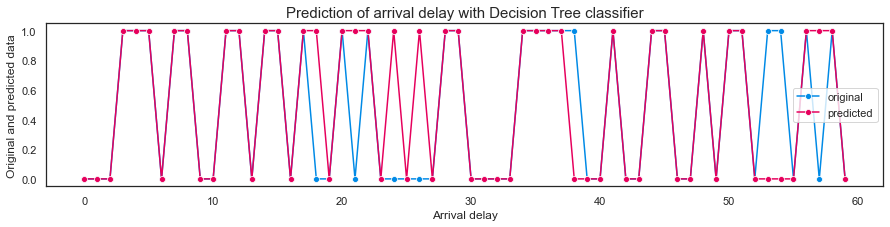

In [425]:
#compare values from test and predict
y1 = y_test.reset_index(drop=True)
y2 = pd.Series(y_pred1)

plt.figure(figsize =(15, 3))

sns.lineplot(data=y1, color='#008ae6',label='original', marker='o')
sns.lineplot(data=y2, color='#e6005c',label='predicted', marker='o')
plt.title("Prediction of arrival delay with Decision Tree classifier",fontsize=15)
plt.xlabel("Arrival delay",fontsize=12)
plt.ylabel("Original and predicted data",fontsize=12)

plt.show()

In [57]:
#comparing f1_scores
f6 = f1_score(y_test, y_pred6)
f7 = f1_score(y_test, y_pred7)
f8 = f1_score(y_test, y_pred8)
f9 = f1_score(y_test, y_pred9)
f10 = f1_score(y_test, y_pred10)

d1 = {'DT': f1, 'KNN': f2, 'SVM': f3, 'Logistic': f4, 'XGBoost': f5}
class1 = pd.Series(data=d1, index=['DT', 'KNN', 'SVM', 'Logistic', 'XGBoost'])

d2 = {'DT': f6, 'KNN': f7, 'SVM': f8, 'Logistic': f9, 'XGBoost': f10}
class2 = pd.Series(data=d2, index=['DT', 'KNN', 'SVM', 'Logistic', 'XGBoost'])

df_class = pd.DataFrame({'First F1_score':class1, 'Second F1_score':class2})
df_class

,First F1_score,Second F1_score
DT,0.896552,0.933333
KNN,0.666667,0.666667
SVM,0.740741,0.877193
Logistic,0.800000,0.821429
XGBoost,0.933333,0.933333


Tuning changes:
- Decision Tree: improvement with splitter='best'
- KNN: no improvement
- SVM: improvement with linear kernel, default was rbf
- LC: improvement with multi_class='multinomial'
- XGB: no improvement, the model was already very accurate

In [58]:
#Cross-validation
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

scores1 = cross_val_score(model1, X_test, y_test, cv=cv)
scores2 = cross_val_score(model2, X_test, y_test, cv=cv)
scores3 = cross_val_score(model3, X_test, y_test, cv=cv)
scores4 = cross_val_score(model4, X_test, y_test, cv=cv)
scores5 = cross_val_score(model5, X_test, y_test, cv=cv)

print(" Decision tree classifier has %0.2f accuracy with a standard deviation of %0.2f" % (scores1.mean(), scores1.std()))
print(" KNN classifier has %0.2f accuracy with a standard deviation of %0.2f" % (scores2.mean(), scores2.std()))
print(" SVM classifier has %0.2f accuracy with a standard deviation of %0.2f" % (scores3.mean(), scores3.std()))
print(" Logistic classifier has %0.2f accuracy with a standard deviation of %0.2f" % (scores4.mean(), scores4.std()))
print(" XGBoost classifier has %0.2f accuracy with a standard deviation of %0.2f" % (scores5.mean(), scores5.std()))

 Decision tree classifier has 0.75 accuracy with a standard deviation of 0.07
 KNN classifier has 0.67 accuracy with a standard deviation of 0.15
 SVM classifier has 0.67 accuracy with a standard deviation of 0.11
 Logistic classifier has 0.75 accuracy with a standard deviation of 0.12
 XGBoost classifier has 0.95 accuracy with a standard deviation of 0.04


Conclusion:
- The best classifier would be Decision Tree and XGBoost classifier.
- The Stratified K-Fold is generelly better for classification problems, another one is ShuffleSplit used for regressions.

## Level 2

### Exercise 5

#### Feature-engineering process to get better prediction.

How can we deal with the outliers?

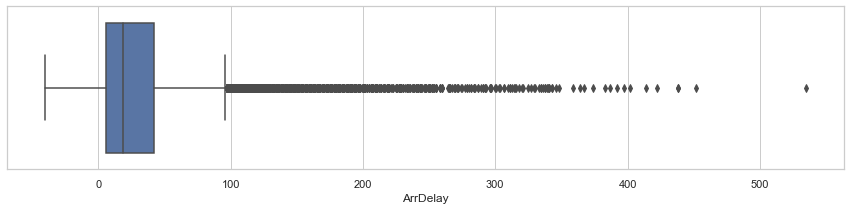

In [60]:
a = df_flights['ArrDelay']
plt.figure(figsize=(15,3))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(a)

In [61]:
#eliminate outliers from Q1 and Q3 - 0.25 0.75
Q1 = a.quantile(q=0.25)
Q3 = a.quantile(q=0.75)
print(Q1, Q3)

6.0 42.0


In [62]:
df_mod = df_flights[(df_flights['ArrDelay'] >= 6) & (df_flights['ArrDelay'] <= 42)]
df_mod.head(3)

,Month,DayofMonth,DayOfWeek,CRSArrTime,CRSElapsedTime,ArrDelay,DepDelay,TaxiIn,TaxiOut,Label
1,1,3,4,1530,65.0,24.0,36.0,4.0,8.0,1
2,1,3,4,1240,65.0,33.0,30.0,3.0,18.0,1
6,1,3,4,1120,65.0,31.0,12.0,22.0,19.0,1


In [63]:
#stratified random sample - take 50 flights with delay and 50 with no delay
group1 = df_mod[df_mod['Label'] == 0]
group2 = df_mod[df_mod['Label'] == 1]
flights_df1 = group1.sample(n = 100)
flights_df2 = group2.sample(n = 100)
df_flights_sample2 = flights_df1.append((flights_df2),ignore_index = True)
df_flights_sample2.head(3)

,Month,DayofMonth,DayOfWeek,CRSArrTime,CRSElapsedTime,ArrDelay,DepDelay,TaxiIn,TaxiOut,Label
0,2,13,3,1925,315.0,31.253548,93.0,5.793312,12.0,0
1,12,17,3,1435,250.0,31.253548,11.0,5.793312,18.0,0
2,12,17,3,1730,175.0,31.253548,148.0,5.793312,7.0,0


In [64]:
X = df_flights_sample2.drop('Label',axis=1)
y = df_flights_sample2['Label']
#Train 70%, test 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [65]:
print(X_train.shape,y_train.shape, X_test.shape, y_test.shape)

(140, 9) (140,) (60, 9) (60,)


In [66]:
#scaling the values
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### Decision tree classifier

In [67]:
model11 = DecisionTreeClassifier(criterion='entropy', splitter='best')
model11 = model11.fit(X_train,y_train)
y_pred11 = model11.predict(X_test)

#### K-Nearest Neighbors classifier

In [68]:
model12 = KNeighborsClassifier(n_neighbors=3, weights='distance',leaf_size=40)
model12.fit(X_train, y_train)
y_pred12 = model12.predict(X_test)

#### Support vector machine classifier

In [69]:
model13 = svm.SVC(kernel='linear', coef0=1.0, random_state=42)
model13.fit(X_train, y_train)
y_pred13 = model13.predict(X_test)

#### Logistic classifier

In [70]:
model14 = LogisticRegression(class_weight='balanced',solver= 'newton-cg', multi_class='multinomial', random_state=42)
model14.fit(X_train,y_train)
y_pred14 = model14.predict(X_test)

#### XGBoost classifier

In [71]:
model15 = xgb.XGBClassifier(colsample_bytree=0.3,learning_rate=0.1,max_depth=10,n_estimators=100,objective='reg:logistic')
model15.fit(X_train,y_train)
predictions = model15.predict(X_test)
y_pred15 = [round(value) for value in predictions]

In [72]:
#comparing f1_scores
f11 = f1_score(y_test, y_pred11)
f12 = f1_score(y_test, y_pred12)
f13 = f1_score(y_test, y_pred13)
f14 = f1_score(y_test, y_pred14)
f15 = f1_score(y_test, y_pred15)

d1 = {'DT': f1, 'KNN': f2, 'SVM': f3, 'Logistic': f4, 'XGBoost': f5}
class1 = pd.Series(data=d1, index=['DT', 'KNN', 'SVM', 'Logistic', 'XGBoost'])
d2 = {'DT': f6, 'KNN': f7, 'SVM': f8, 'Logistic': f9, 'XGBoost': f10}
class2 = pd.Series(data=d2, index=['DT', 'KNN', 'SVM', 'Logistic', 'XGBoost'])
d3 = {'DT': f11, 'KNN': f12, 'SVM': f13, 'Logistic': f14, 'XGBoost': f15}
class3 = pd.Series(data=d3, index=['DT', 'KNN', 'SVM', 'Logistic', 'XGBoost'])

df_class = pd.DataFrame({'First F1_score':class1, 'Second F1_score':class2, 'Third F1_score':class3})
df_class

,First F1_score,Second F1_score,Third F1_score
DT,0.896552,0.933333,0.982456
KNN,0.666667,0.666667,0.792453
SVM,0.740741,0.877193,0.851852
Logistic,0.800000,0.821429,0.857143
XGBoost,0.933333,0.933333,1.000000


Conclusions:
- Tuning of the initial models improved the performance.
- The feature engineering also improved Decision Tree and XGBoost classifier.

## Level 3

### Exercise 6

#### Prediction without feature DepDelay.

In [73]:
df_flights2 = df_flights.copy()
df_flights2.drop('DepDelay',axis=1, inplace=True)
df_flights2.head(3)

,Month,DayofMonth,DayOfWeek,CRSArrTime,CRSElapsedTime,ArrDelay,TaxiIn,TaxiOut,Label
0,1,3,4,1940,250.0,57.0,3.0,7.0,1
1,1,3,4,1530,65.0,24.0,4.0,8.0,1
2,1,3,4,1240,65.0,33.0,3.0,18.0,1


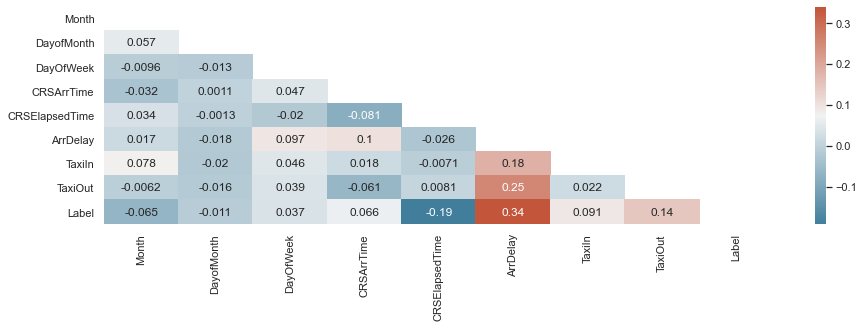

In [74]:
#Correlation matrix
fig,ax = plt.subplots(figsize=(15,4))
corr = df_flights2.corr()
sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)

matrix = np.triu(corr)
sns.heatmap(corr, annot=True, mask=matrix, cmap=cmap)
plt.show()

In [75]:
#stratified random sample - take 50 flights with delay and 50 with no delay
group1 = df_flights2[df_flights2['Label'] == 0]
group2 = df_flights2[df_flights2['Label'] == 1]
flights_df1 = group1.sample(n = 100)
flights_df2 = group2.sample(n = 100)
df_flights_sample3 = flights_df1.append((flights_df2),ignore_index = True)
df_flights_sample3.head(3)

,Month,DayofMonth,DayOfWeek,CRSArrTime,CRSElapsedTime,ArrDelay,TaxiIn,TaxiOut,Label
0,2,24,7,2230,120.0,-4.0,5.0,6.0,0
1,1,22,2,2055,65.0,0.0,4.0,9.0,0
2,4,17,4,1650,65.0,0.0,4.0,9.0,0


In [76]:
X = df_flights_sample3.drop('Label',axis=1)
y = df_flights_sample3['Label']
#Train 70%, test 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [77]:
print(X_train.shape,y_train.shape, X_test.shape, y_test.shape)

(140, 8) (140,) (60, 8) (60,)


In [78]:
#scaling the values
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### Decision tree classifier

In [79]:
model16 = DecisionTreeClassifier()
model16 = model16.fit(X_train,y_train)
y_pred16 = model16.predict(X_test)

#### K-Nearest Neighbors classifier

In [86]:
model17 = KNeighborsClassifier(n_neighbors=1, weights='distance',leaf_size=50)
model17.fit(X_train, y_train)
y_pred17 = model17.predict(X_test)

#### Support vector machine classifier

In [81]:
model18 = svm.SVC(kernel='linear', coef0=1.0, random_state=42)
model18.fit(X_train, y_train)
y_pred18 = model18.predict(X_test)

#### Logistic classifier

In [82]:
model19 = LogisticRegression()
model19.fit(X_train,y_train)
y_pred19 = model19.predict(X_test)

#### XGBoost classifier

In [84]:
model20 = xgb.XGBClassifier(objective='reg:logistic')
model20.fit(X_train,y_train)
predictions = model20.predict(X_test)
y_pred20 = [round(value) for value in predictions]

In [87]:
#comparing f1_scores
f16 = f1_score(y_test, y_pred16)
f17 = f1_score(y_test, y_pred17)
f18 = f1_score(y_test, y_pred18)
f19 = f1_score(y_test, y_pred19)
f20 = f1_score(y_test, y_pred20)

d1 = {'DT': f1, 'KNN': f2, 'SVM': f3, 'Logistic': f4, 'XGBoost': f5}
class1 = pd.Series(data=d1, index=['DT', 'KNN', 'SVM', 'Logistic', 'XGBoost'])
d2 = {'DT': f6, 'KNN': f7, 'SVM': f8, 'Logistic': f9, 'XGBoost': f10}
class2 = pd.Series(data=d2, index=['DT', 'KNN', 'SVM', 'Logistic', 'XGBoost'])
d3 = {'DT': f11, 'KNN': f12, 'SVM': f13, 'Logistic': f14, 'XGBoost': f15}
class3 = pd.Series(data=d3, index=['DT', 'KNN', 'SVM', 'Logistic', 'XGBoost'])
d4 = {'DT': f16, 'KNN': f17, 'SVM': f18, 'Logistic': f19, 'XGBoost': f20}
class4 = pd.Series(data=d4, index=['DT', 'KNN', 'SVM', 'Logistic', 'XGBoost'])

df_class = pd.DataFrame({'First F1_score':class1, 'Second F1_score':class2,
                         'Third F1_score':class3,'Fourth F1_score':class4, })
df_class

,First F1_score,Second F1_score,Third F1_score,Fourth F1_score
DT,0.896552,0.933333,0.982456,1.000000
KNN,0.666667,0.666667,0.792453,0.642857
SVM,0.740741,0.877193,0.851852,0.928571
Logistic,0.800000,0.821429,0.857143,0.888889
XGBoost,0.933333,0.933333,1.000000,1.000000


Conclusion:
- Classification without DepDelay are showing better results in some cases. That means that if we work with values which are not strongly correlated we can perform better classification algorithms.
- Probabely the best solution of classification for the dataset would be Decision Tree and XGBoost.

### Exercise extra

#### How to deal with imbalanced data?

#### 1. Change the performance metric

In [88]:
#Previously explored sensitivity(recall) and f_score, but we can also add Precision
#precision TP / (TP + FP)
p1 = m1[1,1] / (m1[1,1] + m1[0,1])
p2 = m2[1,1] / (m2[1,1] + m2[0,1])
p3 = m3[1,1] / (m3[1,1] + m3[0,1])
p4 = m4[1,1] / (m4[1,1] + m4[0,1])
p5 = m5[1,1] / (m5[1,1] + m5[0,1])

print('Precision decision tree model:',p1)
print('Precision KNN model:',p2)
print('Precision SVM model:',p3)
print('Precision Logistic model:',p4)
print('Precision XGBoost model:',p5)

Precision decision tree model: 0.896551724137931
Precision KNN model: 0.6785714285714286
Precision SVM model: 0.8
Precision Logistic model: 0.8461538461538461
Precision XGBoost model: 0.9032258064516129


#### 2. Resampling

In [91]:
from imblearn.over_sampling import SMOTE
from keras.utils import np_utils
X = df_flights.drop('Label',axis=1)
y = df_flights['Label']

#test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=27)
sm = SMOTE(random_state=27)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [92]:
smote = LogisticRegression(solver='liblinear').fit(X_train, y_train)
smote_pred = smote.predict(X_test)

a = metrics.accuracy_score(y_test, smote_pred)
b = f1_score(y_test, smote_pred)
print(a,b)

0.9390856236786469 0.9636177097308815


Conclusion:
- SMOTE method improved significantly the Logistic model comparing the result to previous algorithms. 
- Another method would be undersampling or oversampling. In this large dataset would be appropriate to use undersampling - which was already applied in previous steps.
- SMOTE - generating the synthetics samples seems to be the best way how to deal with imbalanced dataset.

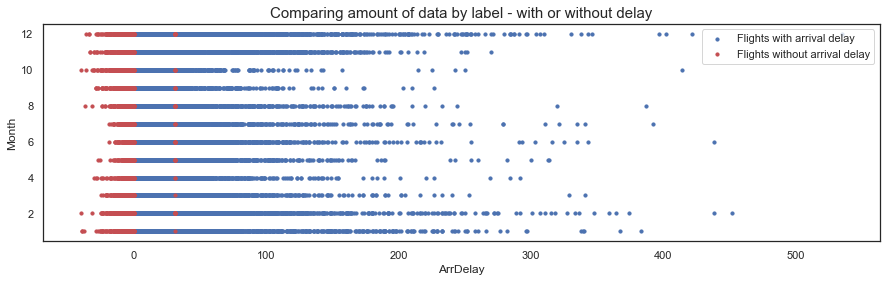

In [561]:
#visualize the majority and minority group
plt.figure(figsize =(15, 4))
idx_1 = np.where(df_flights.Label == 1)
idx_0 = np.where(df_flights.Label == 0)

plt.scatter(df_flights.iloc[idx_1].ArrDelay, df_flights.iloc[idx_1].Month, s=10, c='b', marker="o")
plt.scatter(df_flights.iloc[idx_0].ArrDelay, df_flights.iloc[idx_0].Month, s=10, c='r', marker="o")
plt.title("Comparing amount of data by label - with or without delay",fontsize=15)
plt.xlabel('ArrDelay')
plt.ylabel('Month')
plt.legend(['Flights with arrival delay','Flights without arrival delay' ])
plt.show()

#### Exporting list of requirements

In [410]:
#exporting requirements
conda list -e > requirements.txt


Note: you may need to restart the kernel to use updated packages.


#### Notes
* Freeze
    - https://pip.pypa.io/en/stable/cli/pip_freeze/
* Decision Tree
    - https://www.datacamp.com/community/tutorials/decision-tree-classification-python
* How to evaluate
    - https://towardsdatascience.com/how-to-best-evaluate-a-classification-model-2edb12bcc587
    - https://www.ritchieng.com/machine-learning-evaluate-classification-model/
    - https://towardsdatascience.com/hackcvilleds-4636c6c1ba53
* K-Nearest Neighbors
    - https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/
* Logistic Regression classifier
    - https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python
    - https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a
* Support vector machine
    - https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python
* XGBoost
    - https://www.datacamp.com/community/tutorials/xgboost-in-python
* Cross-validation
    - https://scikit-learn.org/stable/modules/cross_validation.html
    - https://machinelearningmastery.com/k-fold-cross-validation/
* Oversampling/undersampling of imbalanced dataset 
    - https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18
    - https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
* Ensempling method   
    - https://www.kdnuggets.com/2019/05/fix-unbalanced-dataset.html
* SMOTE, ADASYN
    - https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/